In [1]:
import numpy as np
from AdaCapNet import *
from benchmarked_architectures import *
from get_dataset import get_dataset
from copy import deepcopy
import torch
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import roc_auc_score as auc


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
seed = 0
dataset_id = 12 #Abalone
input_name = "regression"
input_repository = "./dataset_generation/ablation_datasets/"
train_size = 0.8
should_stratify = True
output_figure_path = "./figures/"
figure_name = "Learning_Dynamic"

# Load data

In [3]:
X_train, X_test, y_train, y_test = get_dataset(dataset_id, 
                                               input_name, 
                                               input_repository, 
                                               should_stratify = should_stratify,
                                               seed = seed)

# Learning dynamic

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def numpyfy_record(new_record):
    new_record = deepcopy(new_record)
    for key in new_record.keys():
        new_record[key] = np.array(new_record[key])
    new_record["rmse"] = new_record["loss"]
    if "validation" in new_record.keys():
        new_record["rmse_valid"] = np.sqrt(1. - new_record["validation"])#from r2-score to rmse
    return deepcopy(new_record)

In [6]:
default_parameters = deepcopy(eval("adacapnetfast"))
default_parameters["hidden_params"]["n_features"] = X_train.shape[-1]
reg = AdaCapNetRegressor(random_state = seed, **default_parameters)
reg.fit(X_train,y_train)
adacapnet_record = reg.record
adacapnet_record = numpyfy_record(adacapnet_record)
print("AdaCapMLPfast","R2-score :",reg.score(X_test, y_test))
if "reg" in locals().keys():
    reg.delete_model_weights()  #else gpu memory leaks
    del reg
    
default_parameters = deepcopy(eval("adacapnetfast"))
default_parameters["hidden_params"]["n_features"] = X_train.shape[-1]
default_parameters["permutation_scale"] = False
reg = AdaCapNetRegressor(random_state = seed, **default_parameters)
reg.fit(X_train,y_train)
tikhonov_record = reg.record
tikhonov_record = numpyfy_record(tikhonov_record)
print("TikhonovMLPfast","R2-score :",reg.score(X_test, y_test))
if "reg" in locals().keys():
    reg.delete_model_weights()  #else gpu memory leaks
    del reg
    
NN_params = deepcopy(eval("adacapnetfast"))
NN_params["hidden_params"]["n_features"] = X_train.shape[-1]
NN_params["hidden_params"]["output"] = 1
NN_params["closeform_parameter_init"] = False
reg = AdaCapNetRegressor(random_state = seed, **NN_params)
reg.fit(X_train,y_train)
regularnet_record = reg.record
regularnet_record = numpyfy_record(regularnet_record)
print("MLPfast","R2-score :",reg.score(X_test, y_test))
if "reg" in locals().keys():
    reg.delete_model_weights()  #else gpu memory leaks
    del reg

AdaCapMLPfast R2-score : 0.5786722865645817
TikhonovMLPfast R2-score : 0.5791112705643409
MLPfast R2-score : 0.5717341696385565


In [7]:
pretty_metric = {"rmse":": Train set", "rmse_valid":"Validation set"}
compared_methods = {"AdaCap":"adacapnet","Tikhonov":"tikhonov", "Regular":"regularnet"}
line_code = {"rmse":"-","rmse_valid":"--"}
color_code = {"AdaCap":"tab:blue","Tikhonov":"tab:orange", "Regular":"tab:green"}
start_x_code = {"AdaCap":0,"Tikhonov":0, "Regular":2}# Do not plot first 2 iterations of Regular MLP, to improve visibility
def gen_label(method, metric):
    if pretty_metric[metric]==None:
        return None
    return method + " "+pretty_metric[metric]

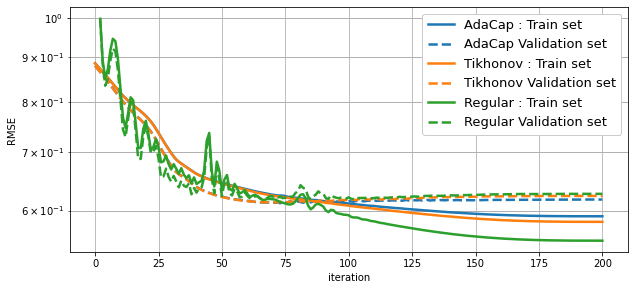

In [8]:
add_title = False #No title on ICML plots
plt.rcParams["figure.figsize"] = (10,4.5)
if add_title: plt.title("Learning Dynamic: RMSE Loss across iterations, Dataset : Abalone")
for method_name, record_name in compared_methods.items():
    for metric in ["rmse", "rmse_valid"]:
        y_values = eval(record_name+"_record")[metric]
        x_values = np.arange(len(y_values))
        start = start_x_code[method_name]
        plt.semilogy(x_values[start:], y_values[start:], 
                     linewidth = 2.5,
                     color = color_code[method_name], 
                     linestyle = line_code[metric], 
                     label = gen_label(method_name, metric))

plt.legend(prop={'size': 13}, framealpha=1.)
plt.xlabel("iteration")
plt.ylabel("RMSE")
plt.grid(which = "major", axis = "x")
plt.grid(which = "both", axis = "y", linewidth = 1)
plt.savefig(output_figure_path + figure_name+".pdf", dpi='figure', format="pdf",bbox_inches='tight')